# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torch
!pip install torchvision

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 16.1 MB/s            
     |████████████████████████████████| 83 kB 192 kB/s             
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes ins

In [5]:
import sagemaker
import boto3

# import some dependencies
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

## Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-03-12 11:23:14--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 65.8.158.9, 65.8.158.122, 65.8.158.25, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.8.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   202MB/s    in 0.2s    

2022-03-12 11:23:15 (202 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/an

In [6]:
# get the sagemaker session
sagemaker_session = sagemaker.Session()

# get s3 bucket
bucket = sagemaker_session.default_bucket()
# bucket = "ant-bees-bucket"

# set the prefix
prefix = "project-hymenoptera/antbees"

# get the sagemaker execution role
role = sagemaker.get_execution_role()

# upload the data to s3 bucket
print(f"Uploading images...")
inputs = sagemaker_session.upload_data(path="hymenoptera_data", bucket = bucket, key_prefix = prefix)

print(f"input spec (s3 path): {inputs}")

Uploading images...
input spec (s3 path): s3://sagemaker-us-west-1-744298237251/project-hymenoptera/antbees


In [13]:
def get_item(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() # turn off gradients during inference for memory effieciency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    for batch in dataloader:
        images, labels = batch
        preds = model(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
        
    return all_preds


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Hyperparameter Tuning

Hyperparameter tuning can make the difference between an average model and a highly accurate one. Often simple things like choosing a different learning rate or changing a network layer size can have a dramatic impact on your model performance.

1. In machine learning and statistics, the learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.
2. Weight Decay, or Regularization, is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the Norm of the weights
3. Batch size is a number that indicates the number of input feature vectors of the training data. This affects the optimization parameters during that iteration.

In [7]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges ={
    "lr": sagemaker.tuner.ContinuousParameter(1e-4, 1e-1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64]) #, 256, 512])
}

# metrics
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# TODO: Your HP tuner here
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)

In [10]:
tuner.fit({"training": inputs}, wait=True)

.......................................................................................................................................................................!


In [11]:
tuner.best_training_job()

'pytorch-training-220312-1125-004-0f74d62a'

In [16]:
# The best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-03-12 11:34:55 Starting - Preparing the instances for training
2022-03-12 11:34:55 Downloading - Downloading input data
2022-03-12 11:34:55 Training - Training image download completed. Training in progress.
2022-03-12 11:34:55 Uploading - Uploading generated training model
2022-03-12 11:34:55 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.01370897467531476',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-03-12-11-25-13-562"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-west-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-1-744298237251/pytorch-training-2022-03-12-11-25-13-562/source/sourcedir.tar.gz"'}

In [17]:
best_hyperparameters= {'batch-size': int(best_estimator.hyperparameters()['batch-size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],

                      }

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [18]:
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs, CollectionConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_configs = [CollectionConfig(name="CrossEntopyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train_save_interval": "100", "eval.save_interval": "10"
})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
   collection_configs = collection_configs
)

In [19]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="ant-bees-estimator2",
    role=role,
    instance_count=1,
    instance_type= "ml.m5.2xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config = profiler_config
)

In [20]:
estimator.fit({"training": inputs}, wait=True)

2022-03-12 11:57:27 Starting - Starting the training job...
2022-03-12 11:57:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2022-03-12 11:58:53 Downloading - Downloading input data...
2022-03-12 11:59:24 Training - Downloading the training image....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-12 12:00:01,725 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-12 12:00:01,728 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-12 12:00:01,738 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-12 12:00:01,743 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-12 12:00:02,256 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)

In [21]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

region = sagemaker_session.boto_region_name
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

train_job = TrainingJob(training_job_name, region)
train_job.wait_for_sys_profiling_data_to_be_available()


test_trial = create_trial(estimator.latest_job_debugger_artifacts_path())
test_trial.tensor_names()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-west-1-744298237251/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/profiler-output


Profiler data from system is available
[2022-03-12 12:02:41.610 datascience-1-0-ml-t3-medium-0943ed5e601f607095bd0313c49c:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sag

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight']

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


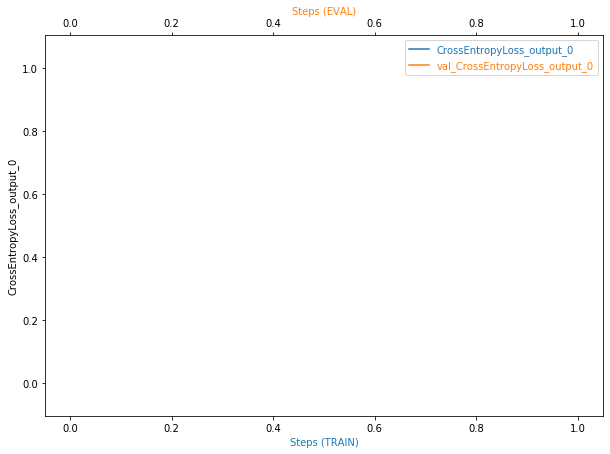

In [26]:
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(data, tname, mode):
    tensor = data.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(test_trial, "CrossEntropyLoss_output_0")

* Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
* If not, suppose there was an error. What would that error look like and how would you have fixed it?

There is no error from the estimator created and the output or cloudwatch logs. 

Loss decreases steadily and also accuracy increases. However, I had issues with smdebug hooks, thus the graph did not show any plots. I will have to find why it is not compatible with my model and fix it. Also, if the loss was increasing, I would try using different learning rates. if model overfits, I will also try data augmentation as well.

In [29]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

# check system utilization
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Path to profiler: {rule_output_path}")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-west-1-744298237251/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/profiler-output


Profiler data from system is available
[2022-03-12 12:07:20.925 datascience-1-0-ml-t3-medium-0943ed5e601f607095bd0313c49c:20 INFO metrics_reader_base.py:134] Getting 4 event files
select ev

Path to profiler: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output


In [42]:
! aws s3 ls {rule_output_path} --recursive

2022-03-12 12:02:28     366791 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-12 12:02:27     221212 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-12 12:02:23        191 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-12 12:02:23        199 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-12 12:02:23       2000 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-12 12:02:23        127 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-03-12 12:02:23        198 ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profil

In [43]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-2022-03-12-11-57-26-675/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-west-1-744298237251/ant-bees-estimator2-

## Model Deploying

In [31]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------!

In [39]:
# TODO: Run an prediction on the endpoint
import PIL
import torchvision.transforms as transforms
import numpy as np

def make_inference(image_path: str):

    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    PIL_image = PIL.Image.open(image_path)

    image = transform(PIL_image)

    payload = image.unsqueeze(dim=0)

    response = predictor.predict(payload)

    np.argmax(response) + 1
    return response

In [40]:
make_inference("./hymenoptera_data/val/bees/2103637821_8d26ee6b90.jpg")

array([[-6.61810875,  6.17702055]])

In [44]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()